In [1]:
from __future__ import division, print_function
from collections import Counter, defaultdict

import random
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8) # default size of plots

Using TensorFlow backend.


In [2]:
class Trace:
    def __init__(self, fileAddr):
        self.fileAddr = fileAddr

    def readFile(self):
        instructions = []
        dataAddr = []
        with open(self.fileAddr) as f:
            lines = f.readlines()
            for line in lines:
                data = line.split(' ')
                trace_type = int(data[0],  10)
                addr = int(data[1],  16)
                if trace_type in [0,1]:
                    dataAddr.append(addr)
                elif trace_type == 2:
                    instructions.append(addr)
                else:
                    print(data[0])
        self.dataAddr = np.array(dataAddr)
        self.instructions = np.array(instructions)

2 0 : This is an instruction fetch at hex address 0.

0 1000 : This is a data read at hex address 1000.

1 70f60888 : This is a data write at hex address 70f60888.

In [3]:
trace = Trace('trace.din')
trace.readFile()
print(trace.instructions.shape)
print(trace.dataAddr.shape)
dataAddr = trace.dataAddr

(597309,)
(235168,)


In [4]:
counts = Counter()
locations = {}
for t, addr in enumerate(dataAddr):
    counts[addr] += 1
    if addr in locations:
        locations[addr].append(t)
    else:
        locations[addr] = [t]

# number of unique addresses in data read/write
len(counts), len(locations)

(38026, 38026)

In [5]:
temporal_diffs = dict.fromkeys(locations)
for k,v in locations.items():
    temporal_diffs[k] = [v[i+1]-v[i] for i in range(len(v)-1)]

In [6]:
freqs = sorted(counts.items(), key=lambda x:x[1] ,reverse=True)
top_inds = np.array([a for a,b in freqs[:20]])
freqs[:20]

[(268474456, 22404),
 (268474460, 22401),
 (2147418264, 14927),
 (2147418268, 14927),
 (2147418272, 14927),
 (2147418276, 14927),
 (2147418280, 14927),
 (2147418284, 14927),
 (2147418288, 14927),
 (2147418292, 14927),
 (268479660, 7464),
 (268479344, 3732),
 (268474464, 9),
 (268474472, 9),
 (2147418136, 6),
 (2147418140, 6),
 (2147418144, 6),
 (2147418148, 6),
 (2147418152, 6),
 (269804941, 5)]

In [7]:
# function to counnt number of addresses with a given number of calls:
count_num_occur = lambda freqs, num: len([k for k,v in freqs if v==num])
print([count_num_occur(freqs, num) for num in range(1,7)])
print(sum([count_num_occur(freqs, num) for num in range(1,10)]))

[29777, 36, 2958, 5200, 36, 5]
38014


235168 - 38014 = 197154 out of 235168 addresses are from 12 addresses. 

In [8]:
print(temporal_diffs[2147418136])
print(locations[2147418136])

[23, 64516, 23, 64516, 23]
[53034, 53057, 117573, 117596, 182112, 182135]


In [9]:
temporal_strides = []
for k,v in temporal_diffs.items():
    if len(v)>0:
        temporal_strides += v

stride_counter = Counter()
for item in temporal_strides:
    stride_counter[item] += 1
stride_counter = sorted(stride_counter.items(), key=lambda x:x[0])

In [10]:
stride_counter

[(1, 9),
 (2, 14929),
 (3, 7468),
 (4, 7470),
 (6, 3737),
 (7, 3734),
 (8, 6),
 (9, 14921),
 (10, 7468),
 (11, 7459),
 (12, 3734),
 (13, 3734),
 (15, 7462),
 (16, 22386),
 (17, 3),
 (18, 3733),
 (19, 11193),
 (20, 3732),
 (21, 3732),
 (22, 14921),
 (23, 7),
 (25, 7459),
 (28, 14918),
 (31, 3728),
 (32, 3731),
 (43, 6),
 (46, 3),
 (49, 6),
 (52, 3),
 (54, 1),
 (55, 6),
 (58, 3),
 (63, 3727),
 (90, 3),
 (306, 72),
 (64516, 4),
 (64521, 2),
 (64522, 2),
 (64523, 2),
 (64529, 2),
 (64532, 2),
 (64539, 20484),
 (64845, 1140)]

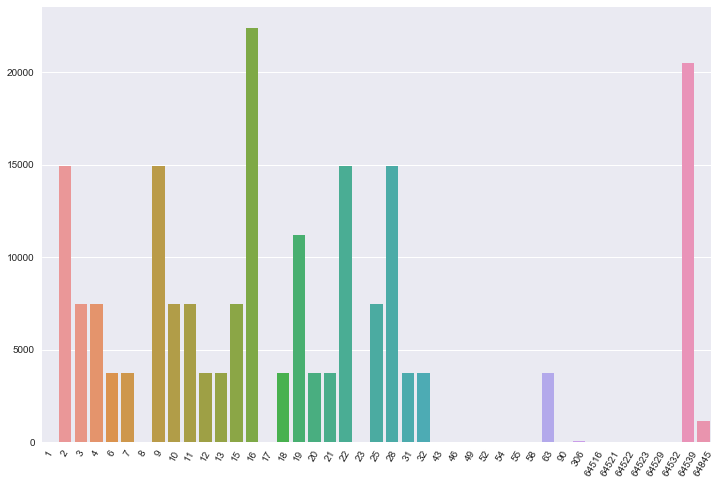

In [10]:
objects = [item[0] for item in stride_counter]
x = np.arange(len(objects))
y = [item[1] for item in stride_counter]

g = sns.barplot(objects,y)
lbl = g.set_xticklabels(objects,rotation = 60)

###### TODO: final metric for temporal stride and spatial stirde (Gaussian weights)

### LSTM Analysis

In [38]:
tmp = [bin(addr) for addr in dataAddr]
tags = [int(item[:-6],2) for item in tmp]
len(tags)

235168

In [39]:
np.unique(tags).shape

(602,)

In [40]:
tag_strides = [tags[k]-tags[k-1] for k in range(1,len(tags))]
np.unique(tag_strides).shape

(1353,)

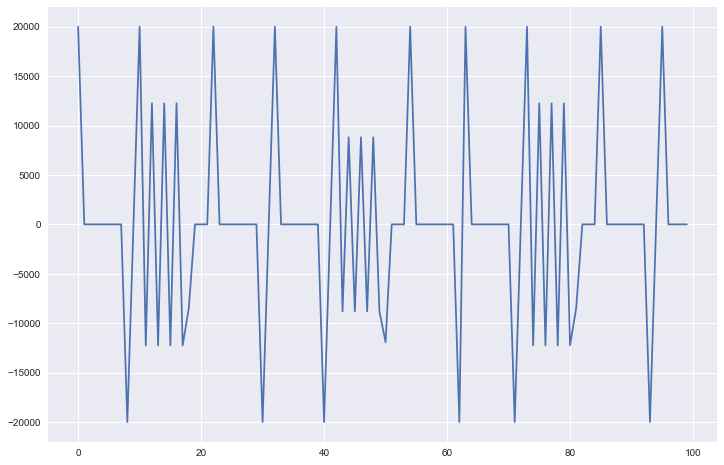

In [14]:
plt.plot(np.clip(tag_strides, -20000, 20000)[:100])

In [17]:
print(tag_strides[:100])

[29358416, 0, 0, 0, 0, 0, 0, 0, -29358497, 0, 20725, -12244, 12244, -12244, 12244, -12244, 12244, -12244, -8481, 0, 0, 0, 29358497, 0, 0, 0, 0, 0, 0, 0, -29358421, 5, 29358416, 0, 0, 0, 0, 0, 0, 0, -29358497, 0, 20725, -8806, 8806, -8806, 8806, -8806, 8806, -8806, -11919, 0, 0, 0, 29358497, 0, 0, 0, 0, 0, 0, 0, -29358416, 29358416, 0, 0, 0, 0, 0, 0, 0, -29358497, 0, 20725, -12244, 12244, -12244, 12244, -12244, 12244, -12244, -8481, 0, 0, 0, 29358497, 0, 0, 0, 0, 0, 0, 0, -29358421, 5, 29358416, 0, 0, 0, 0]


In [50]:
m = np.mean(tag_strides)
s = np.std(tag_strides)
tag_strides_norm = [(item-m)/s for item in tag_strides]

In [51]:
sd = 300
np.random.seed(sd)
seq_len = 500
target_len = 64

data = tag_strides_norm
sequence_length = seq_len + target_len
result = []
for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])

In [52]:
normalise_window = False
if normalise_window:
    result = normalise_windows(result)
result = np.array(result)
row = round(0.9 * result.shape[0])
train = result[:int(row), :]

In [53]:
np.random.shuffle(train)
x_train = train[:, :-target_len]
y_train = train[:, -target_len:]
x_test = result[int(row):, :-target_len]
y_test = result[int(row):, -target_len:]

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
#y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))

In [54]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((211143, 500, 1), (211143, 64), (23460, 500, 1), (23460, 64))

In [55]:
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=False))
model.add(Dropout(0.2))

#model.add(LSTM(
#    100,
#    return_sequences=False))
#model.add(Dropout(0.2))

model.add(Dense(
    output_dim=target_len))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : ', time.time() - start)

compilation time :  0.21441316604614258


In [ ]:
model.fit(
    x_train,
    y_train,
    batch_size=512,
    nb_epoch=5,
    validation_split=0.05)

Train on 200585 samples, validate on 10558 samples
Epoch 1/5
 73728/200585 [==========>...................] - ETA: 1182s - loss: 0.8837

In [ ]:
# TODO metric